# Version 1.0
# 4/12/21
Machine Learning Group Project


Adapted from file "BasicModelsV1.0.py"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc("font", size=17) #Font size
plt.rcParams["figure.figsize"] = (10,10) #Fig size

# Checking csv and titles by importing first row of a file

In [20]:
file_dir="../SpotifyData/"
file_name="ClassicRock_3Ho3iO0iJykgEQNbjB2sic.csv"

test_csv = pd.read_csv(file_dir+file_name, index_col=0, nrows=1) 
display(test_csv)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name
0,0.31,0.7,9,-5.678,1,0.047,0.011,0.00965,0.0828,0.763,188.386,audio_features,08mG3Y1vljYA6bvDt4Wqkj,spotify:track:08mG3Y1vljYA6bvDt4Wqkj,https://api.spotify.com/v1/tracks/08mG3Y1vljYA...,https://api.spotify.com/v1/audio-analysis/08mG...,255493,4,Back In Black


# Compiling Data
Next step is to make a single dataframe holding the data from all source files


In [21]:
file_dir="../SpotifyData/"

file_names= ["JazzClassic_37i9dQZF1DXbITWG1ZJKYt.csv",\
             "CountryHits_1mJhSx6aYQmINsZ8dG4gzU.csv",\
             "ClassicalStudy_6wObnEPQ63a4kei1sEcMdH.csv",\
             "HipHopClassics_5CRJExGSQFYXem2hT5GFkd.csv",\
            "ClassicRock_3Ho3iO0iJykgEQNbjB2sic.csv",\
             "KpopClassics_0jB4ANR4ox65etDMnxvGLp.csv",\
             "HeavyMetalClassics_27gN69ebwiJRtXEboL12Ih.csv",\
             "DanceHits_5oKz4DsTP8zbL97UIPbqp4.csv"]

#file_nrows=[ 200, 205, 227,229, 299, 322, 385, 434]


# tempo_column=11
# mode 5
parameter_columns = [1,2,5,6,7,8,9,10,11]



## Most convenient to set up dataframe with initial file, then systematically loop through the others
## 1 indexing here more natural
playlist_number=1
data = pd.read_csv(file_dir+file_names[playlist_number-1], usecols=parameter_columns)#, nrows=file_nrows[0])

playlist_numbers = playlist_number*np.ones(len(data))
data["playlist_number"]=playlist_numbers #Now has extra playlist column



# Now looping through the remaining filenames
for playlist_number in range(2,len(file_names)+1):
    ## dtmp := Temporary dataframe, will append to df.data once data filtered and prepped
    dtmp= pd.read_csv(file_dir+file_names[playlist_number-1], usecols=parameter_columns)
    
    ## Incase we want to use const number of songs per playlist
    #dtmp= pd.read_csv(file_dir+file_names[playlist_number-1], usecols=parameter_columns), \
    #                  nrows=200)

    playlist_numbers = playlist_number*np.ones(len(dtmp)) # array of playlist_number
    dtmp["playlist_number"]=playlist_numbers #Now has extra playlist column
    data=data.append(dtmp, ignore_index=True) #Append back to main df.data
    

    
## Removing duplicates
print("Removing n duplicates = ", data.duplicated().sum()) #prints number of duplicates
data = data.drop_duplicates() 
display(data.head())

## Reseting indexing after dropping duplicates
data.reset_index(drop=True, inplace=True)

#X = data.loc[:,"danceability":"tempo"]
X = data.loc[:,"danceability":"tempo"]
Y = data.loc[:,"playlist_number"]
X_norm = data.iloc[:, [0,1,3,4,5,6,7]]#Just 7 normalized_params

#Numpy array more convenient
X=np.array(X);Y=np.array(Y)
X_norm = np.array(X_norm) 
classes=np.array([1,2,3,4,5,6,7,8])

Removing n duplicates =  24


,danceability,energy,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_number
0,0.639,0.2690,1,0.0698,0.982,0.120000,0.141,0.539,124.866,1.0
1,0.419,0.0284,1,0.0357,0.987,0.586000,0.105,0.121,71.502,1.0
2,0.573,0.2470,0,0.0627,0.713,0.000056,0.103,0.604,138.234,1.0
3,0.593,0.1030,1,0.0810,0.986,0.600000,0.120,0.443,66.283,1.0
4,0.450,0.0288,1,0.0467,0.994,0.895000,0.118,0.358,130.838,1.0


# Useful Library Functions

In [31]:
from sklearn.model_selection import KFold    
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True) #important to shuffle for our ordered data


from sklearn.preprocessing import PolynomialFeatures
q_poly = [1,2,3,4,5]      
## Usage:
    #Xpoly = PolynomialFeatures(q, include_bias=False).fit_transform(X)


#Pipelining output from StandardScaler into input of model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler #Rescale data
## Usage:
    #pipe = make_pipeline(StandardScaler(), ...model...)

# Useful User-defined Functions

In [62]:
def fit_and_score_model(input_model, X, Y, accuracy, accuracy_err, kf):
    scores=[]
    for train, test in kf.split(X):
        input_model.fit(X[train], Y[train])
        scores.append( input_model.score(X[test], Y[test]))
    
    accuracy.append( np.array(scores).mean())
    accuracy_err.append( np.array(scores).std())
    return accuracy, accuracy_err


def fit_and_score_for_Q(input_model, X, Y, q_poly, kf):
    accuracy=[]
    accuracy_err=[]
    for q in q_poly:

        scores=[]
        Xpoly = PolynomialFeatures(q, include_bias=False).fit_transform(X)

        for train, test in kf.split(Xpoly):
            input_model.fit(Xpoly[train], Y[train])
            scores.append( input_model.score(Xpoly[test], Y[test]))

        accuracy.append( np.array(scores).mean())
        accuracy_err.append( np.array(scores).std())

    return accuracy, accuracy_err


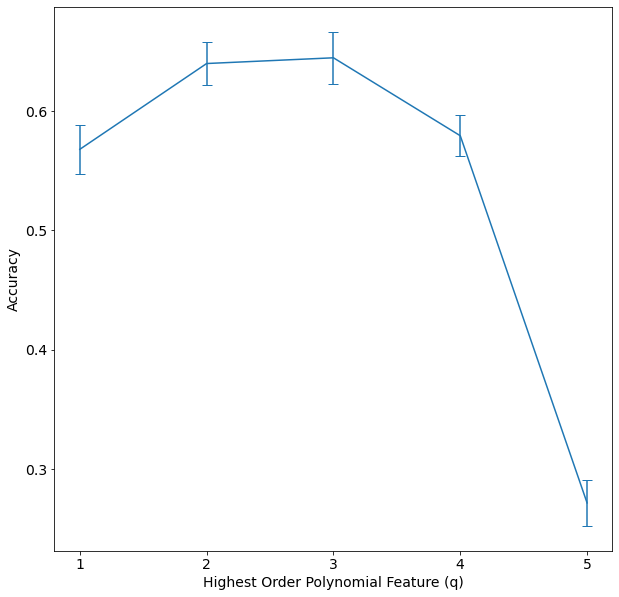

In [64]:
from sklearn.linear_model import RidgeClassifier
#Imitating Linear Classifier we small alpha
C0 = 1e6

pipe = make_pipeline(StandardScaler(), \
        RidgeClassifier(alpha = 1/C0 ))

################################

q_poly = [1,2,3,4,5]
accuracy, accuracy_err = fit_and_score_for_Q(pipe, X, Y, q_poly, kf)


plt.errorbar(q_poly, accuracy, yerr=accuracy_err, capsize=5)
plt.xticks(q_poly)
plt.xlabel("Highest Order Polynomial Feature (q)")
plt.ylabel("Accuracy")
#plt.title("Linear Classifier with Polynomial Features")

#plt.savefig("../Images/LinearClassifier_NormalParams.png")    
plt.show()

# Comparing normalized vs non-normalized input data

In [56]:
from sklearn.linear_model import LogisticRegression


pipe = make_pipeline(StandardScaler(), \
        LogisticRegression(penalty="none", multi_class="multinomial", solver="sag"))#, tol=1e-3, max_iter=5e2))

model= LogisticRegression(penalty="none", multi_class="multinomial", solver="sag")#, tol=1e-3, max_iter=5e2))


################################

q_poly = [1,2,3,4,5]
accuracy=[]
accuracy_err=[]

accuracy_pipe=[]
accuracy_err_pipe=[]
for q in q_poly:
    Xpoly = PolynomialFeatures(q, include_bias=False).fit_transform(X)
    
    accuracy, accuracy_err = fit_and_score_model(model, Xpoly, Y, accuracy, accuracy_err, kf)
    accuracy_pipe, accuracy_err_pipe = fit_and_score_model(pipe, Xpoly, Y, accuracy_pipe, accuracy_err_pipe, kf)


C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

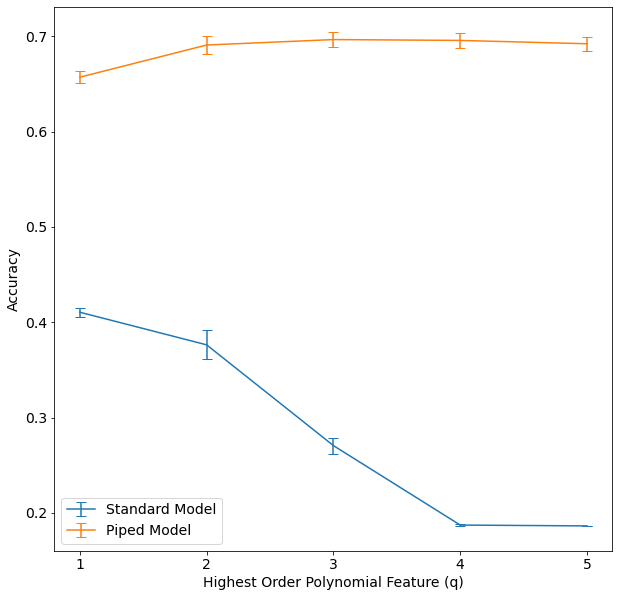

In [44]:
plt.errorbar(q_poly, accuracy, yerr=accuracy_err, capsize=5, label="Standard Model")
plt.errorbar(q_poly, accuracy_pipe, yerr=accuracy_err_pipe, capsize=5, label="Piped Model")
plt.xticks(q_poly)
plt.xlabel("Highest Order Polynomial Feature (q)")
plt.ylabel("Accuracy")

plt.legend()
plt.savefig("../Images/Normalized_vs_NonNormalized.png") 
plt.show()

# LinearClassifier
1) Choose q with Linear Classifier


2) Move to ridge classifier and choose C

[0.566587968827978, 0.6397836769165803, 0.6437291258781527, 0.5854677722753273, 0.27958654842796266] 
 [0.025110105363531646, 0.015666698769597243, 0.019991270697958613, 0.022142950079141372, 0.01173263566264796]


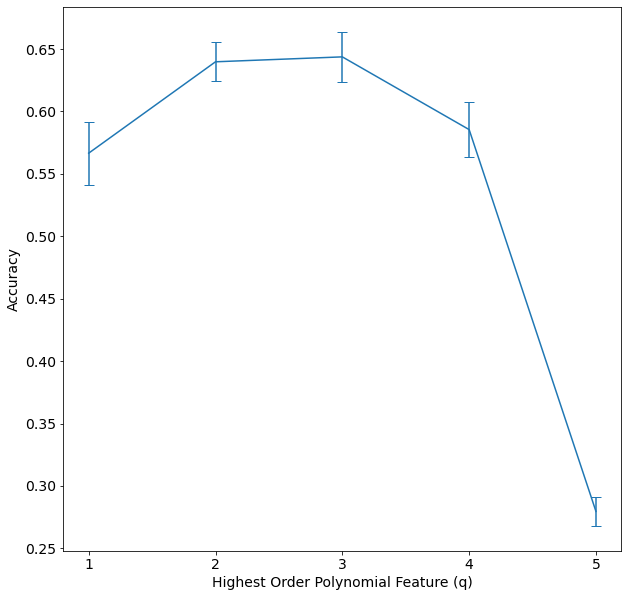

In [65]:
from sklearn.linear_model import RidgeClassifier
#Imitating Linear Classifier we small alpha
C0 = 1e6

pipe = make_pipeline(StandardScaler(), \
        RidgeClassifier(alpha = 1/C0 ))

################################

q_poly = [1,2,3,4,5]

accuracy, accuracy_err = fit_and_score_for_Q(pipe, X, Y, q_poly, kf)
print(accuracy, "\n", accuracy_err)

plt.errorbar(q_poly, accuracy, yerr=accuracy_err, capsize=5)
plt.xticks(q_poly)
plt.xlabel("Highest Order Polynomial Feature (q)")
plt.ylabel("Accuracy")
#plt.title("Linear Classifier with Polynomial Features")

#plt.savefig("../Images/LinearClassifier_NormalParams.png")    
plt.show()

In [10]:
#Best accuracy from q_best, save these results for comparison with Ridge Classifier
q_best=3
lin_acc = accuracy[q_best-1]
lin_acc_err=accuracy_err[q_best-1]

print("Best accuracy from Basic Linear Classifier = [%lf +- %lf]" %(lin_acc, lin_acc_err))

Best accuracy from Basic Linear Classifier = [0.650327 +- 0.024120]


[0.6139275979884065, 0.631897577642136, 0.6472628507812199, 0.6538120465276978, 0.6586298898230258, 0.6415342239625321, 0.6516257821797382] 
 [0.016866539748948875, 0.018441578082849033, 0.0244827272273118, 0.01118221288748753, 0.01890883037494046, 0.015404062838733678, 0.013388026437735966]


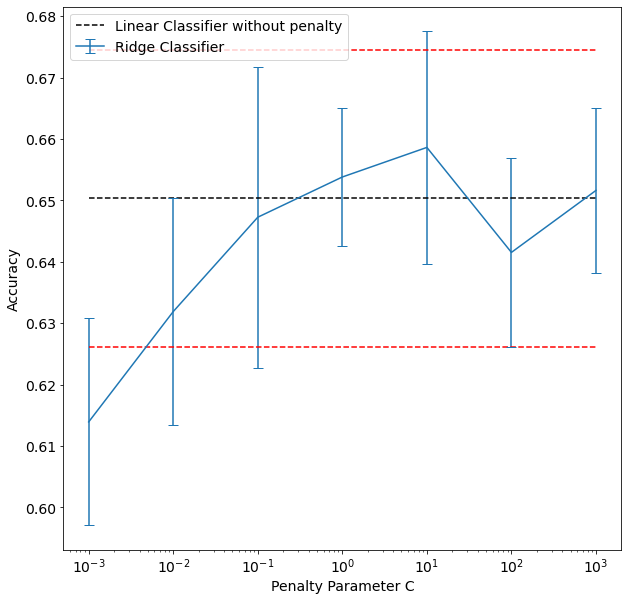

In [60]:
from sklearn.linear_model import RidgeClassifier
#Tuning hyperparameter C now, with q_best

################################

Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X)

#Range of penalty parameters, scaling up by *10
Cs = [0.001,0.01,0.1, 1, 10,100,1000]

accuracy=[]
accuracy_err=[]
for c in Cs:
    pipe = make_pipeline(StandardScaler(), \
            RidgeClassifier(alpha = 1/c ))
    
    accuracy, accuracy_err = fit_and_score_model(pipe, Xpoly, Y, accuracy, accuracy_err, kf)

print(accuracy, "\n", accuracy_err)

plt.errorbar(Cs, accuracy, yerr=accuracy_err, capsize=5, label="Ridge Classifier")
plt.hlines( lin_acc + lin_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")
plt.hlines( lin_acc, Cs[0], Cs[-1], linestyles="dashed", color="black", label="Linear Classifier without penalty")
plt.hlines( lin_acc - lin_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")

plt.xticks(Cs)
plt.xscale("log")

plt.xlabel("Penalty Parameter C")
plt.ylabel("Accuracy")
plt.legend()
#plt.title("Accuracy for Linear-Ridge")
    
#plt.savefig("../Images/RidgeClassifier_NormalParams.png")
plt.show()
#C=1, qbest=3

# Repeat For Lasso Model based off Linear q_best

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

[0.6494174440477561, 0.6559992706053975, 0.6537918922031555, 0.6494193635072364, 0.6441533264232792] 
 [0.02555269242466669, 0.006993612582777768, 0.02717128629336583, 0.019731620162660325, 0.022527127319358922]


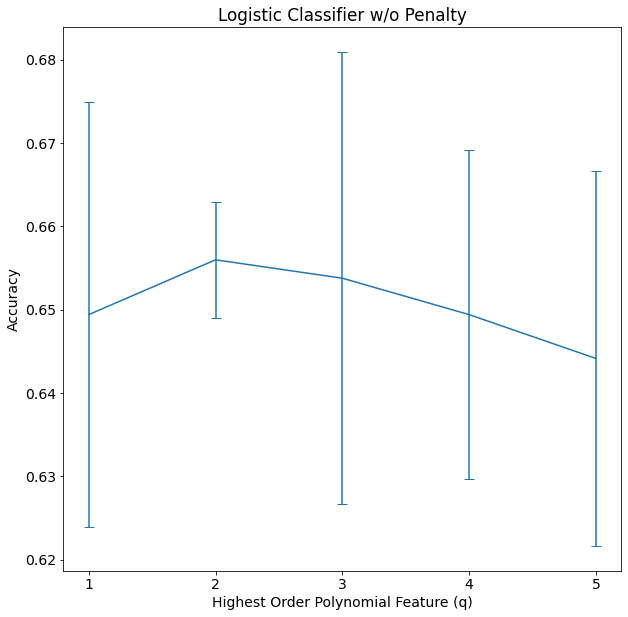

In [66]:
from sklearn.linear_model import LogisticRegression
#Imitating basic model with no penalty

pipe = make_pipeline(StandardScaler(), \
        LogisticRegression(penalty="none", multi_class="multinomial", solver="sag"))#, tol=1e-3, max_iter=5e2))

#########################

q_poly = [1,2,3,4,5]
accuracy, accuracy_err = fit_and_score_for_Q(pipe, X, Y, q_poly, kf)

print(accuracy, "\n", accuracy_err)

plt.errorbar(q_poly, accuracy, yerr=accuracy_err, capsize=5)
plt.xticks(q_poly)
plt.xlabel("Highest Order Polynomial Feature (q)")
plt.ylabel("Accuracy")
#plt.title("Logistic Classifier w/o Penalty")

#plt.savefig("../Images/Logistic_AllParams.png")    
plt.show()


In [7]:
#Best accuracy from q_best, save these results for comparison with Lasso Classifier
q_best=2
log_acc = accuracy[q_best-1]
log_acc_err=accuracy_err[q_best-1]

print("Best accuracy from Basic Logistic Classifier = [%lf +- %lf]" %(log_acc, log_acc_err))

Best accuracy from Basic Logistic Classifier = [0.648547 +- 0.012772]


# Lasso Classifier
Slight adjustment, using L1 penalty with Logistic rahter than Linear model


Note: Smaller C encourages sparsity. May be useful to look at which weights are set to 0

[0.18975872394333754, 0.5206092364390187, 0.6314570616914277, 0.6503167108142346, 0.6555539560059888, 0.6481208491688741, 0.6485527275519214] 
 [0.014868662796962875, 0.01540848455964307, 0.017302704380451343, 0.01299322281594167, 0.01761050003129176, 0.010616563787264572, 0.009802767325720716]


NameError: name 'log_acc' is not defined

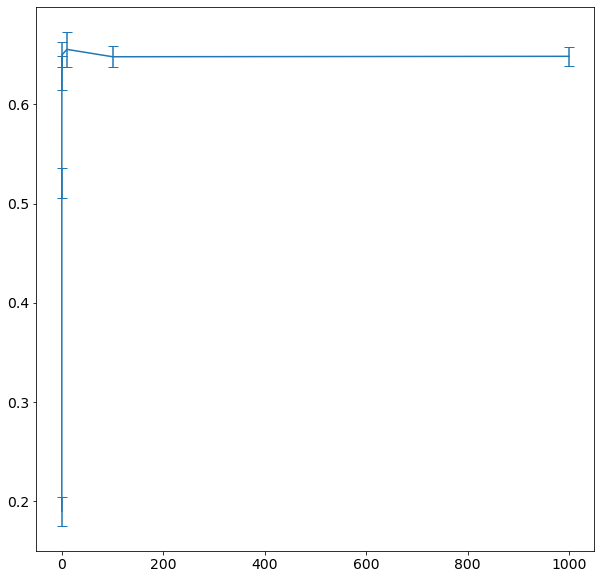

In [67]:
from sklearn.linear_model import LogisticRegression
#Imitating Lasso with Log version


################################

Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X)

#Range of penalty parameters, scaling up by *10
Cs = [0.001,0.01,0.1, 1, 10,100,1000]

accuracy=[]
accuracy_err=[]
for c in Cs:
    pipe = make_pipeline(StandardScaler(), \
        LogisticRegression(penalty="l1", C=c,\
                           multi_class="multinomial", solver="saga",\
                          tol=1e-3, max_iter=5e2
                          ))#, tol=1e-3, max_iter=5e2))

    
    accuracy, accuracy_err = fit_and_score_model(pipe, X, Y, accuracy, accuracy_err, kf)

print(accuracy, "\n", accuracy_err)

plt.errorbar(Cs, accuracy, yerr=accuracy_err, capsize=5, label="Lasso Classifier")
plt.hlines( log_acc + log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")
plt.hlines( log_acc, Cs[0], Cs[-1], linestyles="dashed", color="black", label="Logistic Classifier without penalty")
plt.hlines( log_acc - log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")

plt.xticks(Cs)
plt.xscale("log")

plt.xlabel("Penalty Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Logistic-Lasso")
    
#plt.savefig("../Images/LassoClassifier_AllParams.png")
plt.show()

#C=10, qbest=2

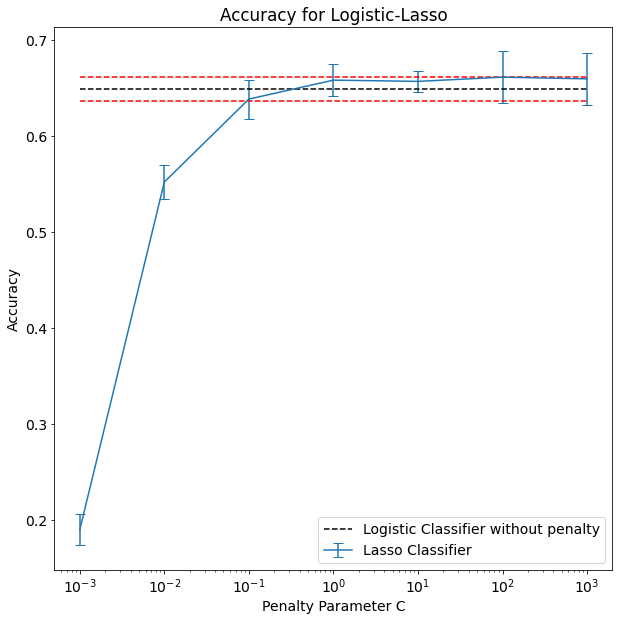

In [10]:
plt.errorbar(Cs, accuracy, yerr=accuracy_err, capsize=5, label="Lasso Classifier")
plt.hlines( log_acc + log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")
plt.hlines( log_acc, Cs[0], Cs[-1], linestyles="dashed", color="black", label="Logistic Classifier without penalty")
plt.hlines( log_acc - log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")

plt.xticks(Cs)
plt.xscale("log")

plt.xlabel("Penalty Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Logistic-Lasso")
    
#plt.savefig("../Images/LassoClassifier_AllParams.png")
plt.show()

# Support Vector Classifier (SVC)

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

[0.6016737686667434, 0.6371626549963529, 0.6529358132749817, 0.6599360819993091, 0.6117365349917463, 0.5359495566048601, 0.5100742830818842] 
 [0.014382459740434752, 0.0159577501145754, 0.028416370219478713, 0.02084822321574165, 0.018607041601186897, 0.023231795561097647, 0.033616005440274585]


C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


NameError: name 'log_acc' is not defined

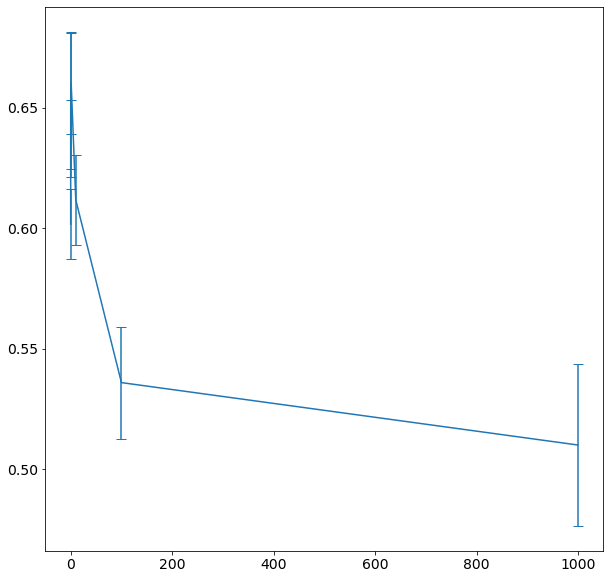

In [73]:
from sklearn.svm import LinearSVC

################################

Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X)

#Range of penalty parameters, scaling up by *10
Cs = [0.001,0.01,0.1, 1, 10,100,1000]

accuracy=[]
accuracy_err=[]
for c in Cs:
    pipe = make_pipeline(StandardScaler(), \
        LinearSVC(C=c, tol=1e-3, max_iter=5e2))

    fit_and_score_model(pipe, Xpoly, Y, accuracy, accuracy_err, kf)
print(accuracy, "\n", accuracy_err)

plt.errorbar(Cs, accuracy, yerr=accuracy_err, capsize=5, label="Linear SVM Classifier")
plt.hlines( log_acc + log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")
plt.hlines( log_acc, Cs[0], Cs[-1], linestyles="dashed", color="black", label="Logistic Classifier without penalty")
plt.hlines( log_acc - log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")

plt.xticks(Cs)
plt.xscale("log")

plt.xlabel("Penalty Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Linear SVM")
    
#plt.savefig("../Images/SVM_AllParams.png")
plt.show()

#C=1, q=2

In [ ]:
plt.errorbar(Cs, accuracy, yerr=accuracy_err, capsize=5, label="Linear SVM Classifier")
plt.hlines( log_acc + log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")
plt.hlines( log_acc, Cs[0], Cs[-1], linestyles="dashed", color="black", label="Logistic Classifier without penalty")
plt.hlines( log_acc - log_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")

plt.xticks(Cs)
plt.xscale("log")

plt.xlabel("Penalty Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Linear SVM")
    
#plt.savefig("../Images/SVM_AllParams.png")
plt.show()

# Linear SVC for just normalized parameters

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

[0.6082527160351645, 0.6380427271680296, 0.6340771238819147, 0.620501746708127, 0.6143757917770356] 
 [0.021621986016871764, 0.028630944829402403, 0.02705715311960732, 0.009981691573780645, 0.018599634664719276]


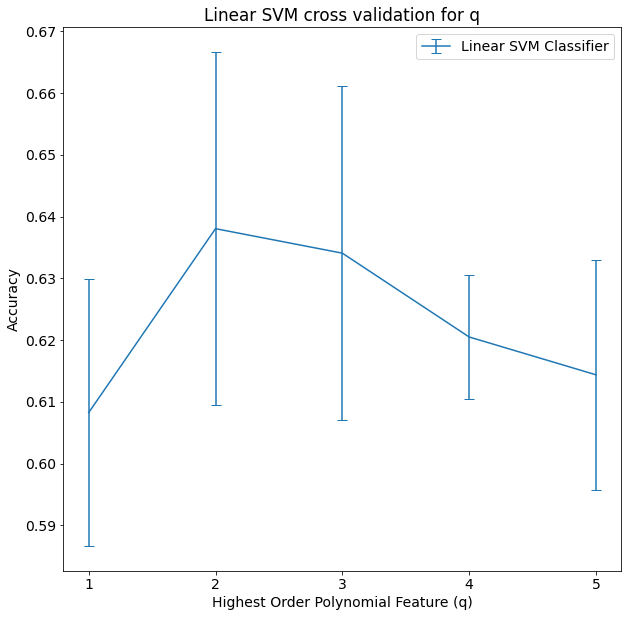

In [36]:
from sklearn.svm import LinearSVC

################################

q_poly = [1,2,3,4,5]

pipe = make_pipeline(StandardScaler(), \
    LinearSVC(C=1, tol=1e-3, max_iter=5e2))


accuracy=[]
accuracy_err=[]
for q in q_poly:
    Xpoly = PolynomialFeatures(q, include_bias=False).fit_transform(X_norm)
    fit_and_score_model(pipe, Xpoly, Y, accuracy, accuracy_err, kf)

print(accuracy, "\n", accuracy_err)

plt.errorbar(q_poly, accuracy, yerr=accuracy_err, capsize=5, label="Linear SVM Classifier")
plt.xticks(q_poly)

plt.xlabel("Highest Order Polynomial Feature (q)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Linear SVM cross validation for q")
    
#plt.savefig("../Images/SVM_NormParams_q.png")
plt.show()

In [ ]:
#Best accuracy from q_best, save these results for comparison with Lasso Classifier
q_best=2
svm_acc = accuracy[q_best-1]
svm_acc_err=accuracy_err[q_best-1]

print("Best accuracy from Linear SVM Classifier = [%lf +- %lf]" %(svm_acc, svm_acc_err))

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

[0.5897971131329418, 0.6108574225498099, 0.6305865868171523, 0.6397740796191793, 0.6240191562056125, 0.5350762025413643, 0.4899285961073362] 
 [0.03744261323291591, 0.01689860949044442, 0.012150426930127163, 0.02929064670380738, 0.022810042244717423, 0.02359176182992029, 0.03680567149472785]


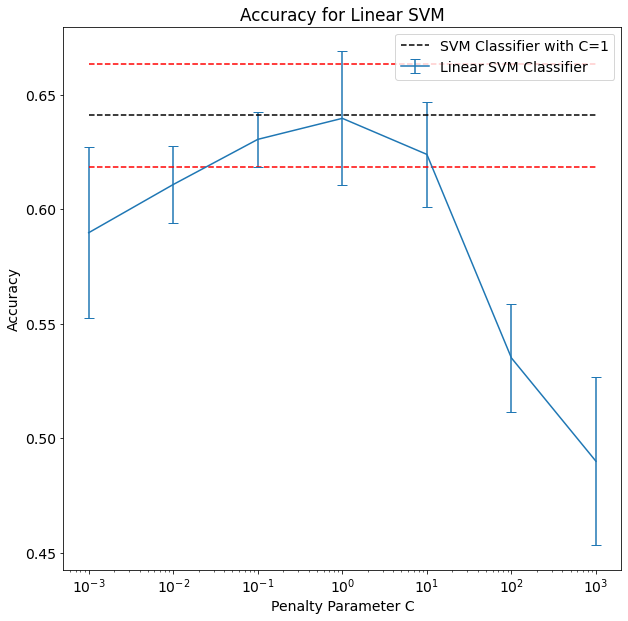

In [38]:
from sklearn.svm import LinearSVC

################################

Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X_norm)

#Range of penalty parameters, scaling up by *10
Cs = [0.001,0.01,0.1, 1, 10,100,1000]

accuracy=[]
accuracy_err=[]
for c in Cs:
    pipe = make_pipeline(StandardScaler(), \
        LinearSVC(C=c, tol=1e-3, max_iter=5e2))

    fit_and_score_model(pipe, Xpoly, Y, accuracy, accuracy_err, kf)
    
print(accuracy, "\n", accuracy_err)

plt.errorbar(Cs, accuracy, yerr=accuracy_err, capsize=5, label="Linear SVM Classifier")
plt.hlines( svm_acc + svm_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")
plt.hlines( svm_acc, Cs[0], Cs[-1], linestyles="dashed", color="black", label="SVM Classifier with C=1")
plt.hlines( svm_acc - svm_acc_err, Cs[0], Cs[-1], linestyles="dashed", color="red")

plt.xticks(Cs)
plt.xscale("log")

plt.xlabel("Penalty Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Linear SVM")
    
#plt.savefig("../Images/SVM_NormParams.png")
plt.show()

#C=1

# k Nearest Neighbours

[0.5942176283158662, 0.616113862336366, 0.6099802295673539, 0.6200794656224808, 0.5977177626780299, 0.6121616952666129, 0.6165486199086337, 0.6073736035932281] 
 [0.026470821697157868, 0.03107737760984998, 0.027982573099248037, 0.009679618631032652, 0.011005642618602242, 0.020790736935989897, 0.017695048777015658, 0.01389256466219117]


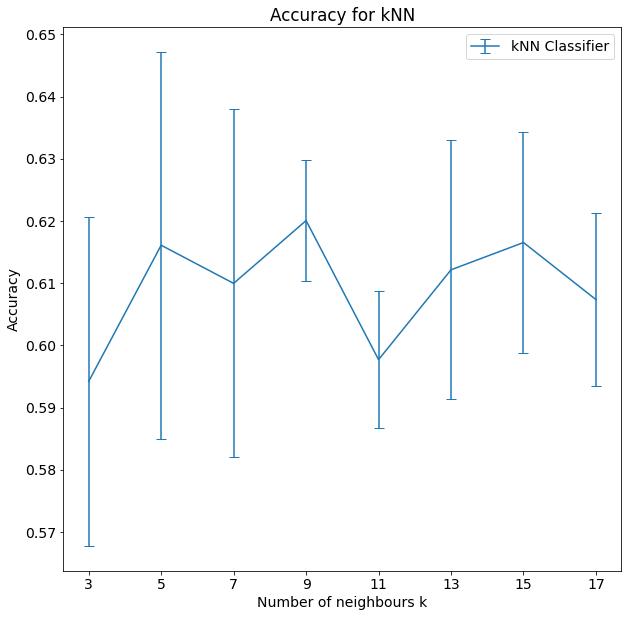

In [69]:
from sklearn.neighbors import KNeighborsClassifier

ks = np.arange(3,18,2)

accuracy=[]
accuracy_err=[]
for k in ks:
    pipe = make_pipeline(StandardScaler(), \
        KNeighborsClassifier(n_neighbors=k, weights="distance") )
    
    accuracy, accuracy_err = fit_and_score_model(pipe, X, Y, accuracy, accuracy_err, kf)
    
print(accuracy, "\n", accuracy_err)
plt.errorbar(ks, accuracy, yerr=accuracy_err, capsize=5, label="kNN Classifier")

plt.xticks(ks)

plt.xlabel("Number of neighbours k")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for kNN")
    
#plt.savefig("../Images/kNN_AllParams.png")
plt.show()
#k=9

[0.5924670812699144, 0.6047506622135207, 0.602544243541019, 0.6104341817344235, 0.6165601366655149, 0.6148115090790434, 0.6060453376329227, 0.6082459979269839] 
 [0.010919746022387752, 0.023071331538573055, 0.008481748939234776, 0.01884830939146966, 0.0158407324057372, 0.029529487112710476, 0.022410495425535824, 0.014274164863292303]


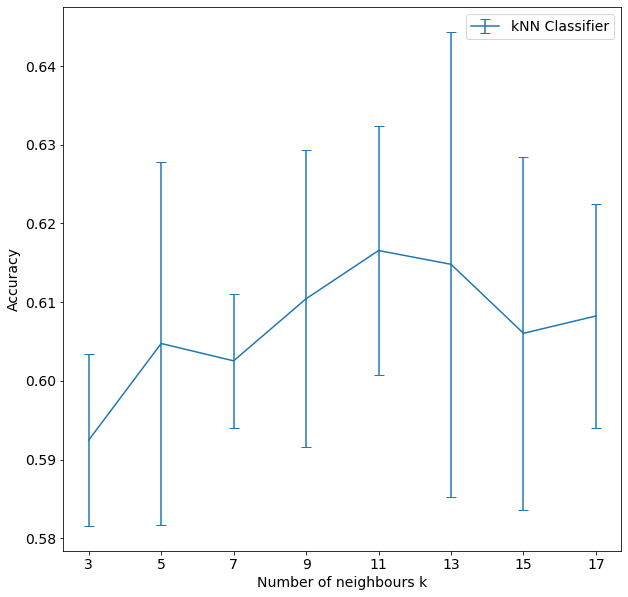

In [71]:
from sklearn.neighbors import KNeighborsClassifier

ks = np.arange(3,18,2)

accuracy=[]
accuracy_err=[]
for k in ks:
    pipe = make_pipeline(StandardScaler(), \
        KNeighborsClassifier(n_neighbors=k, weights="distance") )
    
    accuracy, accuracy_err = fit_and_score_model(pipe, X, Y, accuracy, accuracy_err, kf)

print(accuracy, "\n", accuracy_err)

plt.errorbar(ks, accuracy, yerr=accuracy_err, capsize=5, label="kNN Classifier")

plt.xticks(ks)
plt.xlabel("Number of neighbours k")
plt.ylabel("Accuracy")
plt.legend()
#plt.title("Accuracy for kNN")
    
plt.savefig("../Images/kNN_NormParams.png")
plt.show()
#k=5

# Comparing across parameters

In [72]:
from sklearn.svm import LinearSVC

################################
q_best=2; c=1
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X_norm)
pipe = make_pipeline(StandardScaler(), \
    LinearSVC(C=c, tol=1e-3, max_iter=1e3))

tmp=[]
for train, test in kf.split(Xpoly):
    pipe.fit(Xpoly[train],Y[train])

    #Accuracy
    tmp.append( pipe.score(Xpoly[test], Y[test]) )

accuracy_svm_norm=[0,0]
accuracy_svm_norm[0]= np.array(tmp).mean()
accuracy_svm_norm[1]= np.array(tmp).std()
print(accuracy_svm_norm)



C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.6402347498944299, 0.014052063960059426]


C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [52]:
from sklearn.svm import LinearSVC

################################
q_best=2; c=1
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X)
pipe = make_pipeline(StandardScaler(), \
    LinearSVC(C=c, tol=1e-3, max_iter=1e3))

tmp=[]
for train, test in kf.split(Xpoly):
    pipe.fit(Xpoly[train],Y[train])

    #Accuracy
    tmp.append( pipe.score(Xpoly[test], Y[test]) )

accuracy_svm_all=[0,0]
accuracy_svm_all[0]= np.array(tmp).mean()
accuracy_svm_all[1]= np.array(tmp).std()
print(accuracy_svm_all)



#C=1, q=2

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.6647712004299589, 0.013624627071707238]


C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [54]:
from sklearn.linear_model import LogisticRegression
#Imitating Lasso with Log version

################################
q_best=2; c=10
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X)

pipe = make_pipeline(StandardScaler(), \
        LogisticRegression(penalty="l1", C=c,\
                           multi_class="multinomial", solver="saga",
                           max_iter=1e3))

tmp=[]
for train, test in kf.split(Xpoly):
    pipe.fit(Xpoly[train],Y[train])

    #Accuracy
    tmp.append( pipe.score(Xpoly[test], Y[test]) )

accuracy_lasso_all=[0,0]
accuracy_lasso_all[0]= np.array(tmp).mean()
accuracy_lasso_all[1]= np.array(tmp).std()
print(accuracy_lasso_all)

#C=10, qbest=2

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[0.6564349879074053, 0.018257945694475343]


C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [57]:
from sklearn.linear_model import LogisticRegression
#Imitating Lasso with Log version

################################
q_best=2; c=10
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X_norm)

pipe = make_pipeline(StandardScaler(), \
        LogisticRegression(penalty="l1", C=c,\
                           multi_class="multinomial", solver="saga",
                           max_iter=1e3))

tmp=[]
for train, test in kf.split(Xpoly):
    pipe.fit(Xpoly[train],Y[train])

    #Accuracy
    tmp.append( pipe.score(Xpoly[test], Y[test]) )

accuracy_lasso_norm=[0,0]
accuracy_lasso_norm[0]= np.array(tmp).mean()
accuracy_lasso_norm[1]= np.array(tmp).std()
print(accuracy_lasso_norm)

#C=10, qbest=2

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[0.6450324388652156, 0.0227671482980346]


C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [55]:
from sklearn.linear_model import RidgeClassifier

################################
q_best=3; c=10
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X)
pipe = make_pipeline(StandardScaler(), \
        RidgeClassifier(alpha = 1/c ))

tmp=[]
for train, test in kf.split(Xpoly):
    pipe.fit(Xpoly[train],Y[train])
    #Accuracy
    tmp.append( pipe.score(Xpoly[test], Y[test]) )

accuracy_ridge_all=[0,0]
accuracy_ridge_all[0]= np.array(tmp).mean()
accuracy_ridge_all[1]= np.array(tmp).std()
print(accuracy_ridge_all)
#C=1, qbest=3

#Instant result!

[0.6494299205343775, 0.011771573724566959]


In [56]:
from sklearn.linear_model import RidgeClassifier

################################
q_best=3; c=10
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X_norm)
pipe = make_pipeline(StandardScaler(), \
        RidgeClassifier(alpha = 1/c ))

tmp=[]
for train, test in kf.split(Xpoly):
    pipe.fit(Xpoly[train],Y[train])
    #Accuracy
    tmp.append( pipe.score(Xpoly[test], Y[test]) )

accuracy_ridge_norm=[0,0]
accuracy_ridge_norm[0]= np.array(tmp).mean()
accuracy_ridge_norm[1]= np.array(tmp).std()
print(accuracy_ridge_norm)
#C=1, qbest=3

#Instant result!

[0.6275288878651771, 0.017823936040534165]


In [58]:
from sklearn.neighbors import KNeighborsClassifier

k=9
pipe = make_pipeline(StandardScaler(), \
    KNeighborsClassifier(n_neighbors=k, weights="distance") )
tmp=[]
for train, test in kf.split(X):
    pipe.fit(X[train],Y[train])
    #Accuracy
    tmp.append( pipe.score(X[test], Y[test]) )

accuracy_kNN_all=[0,0]
accuracy_kNN_all[0]= np.array(tmp).mean()
accuracy_kNN_all[1]= np.array(tmp).std()
print(accuracy_ridge_all)
#k=9

[0.6494299205343775, 0.011771573724566959]


In [65]:
from sklearn.neighbors import KNeighborsClassifier

k=5
pipe = make_pipeline(StandardScaler(), \
    KNeighborsClassifier(n_neighbors=k, weights="distance") )
tmp=[]
for train, test in kf.split(X_norm):
    pipe.fit(X_norm[train],Y[train])
    #Accuracy
    tmp.append( pipe.score(X_norm[test], Y[test]) )

accuracy_kNN_norm=[0,0]
accuracy_kNN_norm[0]= np.array(tmp).mean()
accuracy_kNN_norm[1]= np.array(tmp).std()
print(accuracy_kNN_norm)
#k=5

[0.5850205382164383, 0.012635056389393376]


# Combining best results from each model

In [64]:
print(accuracy_ridge_norm,"\n", \
     accuracy_lasso_norm,"\n", \
      accuracy_svm_norm,"\n", \
     accuracy_kNN_norm) 

print("\n\n")
print(accuracy_ridge_all,"\n", \
     accuracy_lasso_all,"\n", \
      accuracy_svm_all,"\n", \
     accuracy_kNN_all)


#Ridge very fast!

[0.6275288878651771, 0.017823936040534165] 
 [0.6450324388652156, 0.0227671482980346] 
 [0.6297199508618373, 0.02081717601453492] 
 [0.5911484126070098, 0.0075029260056232346]



[0.6494299205343775, 0.011771573724566959] 
 [0.6564349879074053, 0.018257945694475343] 
 [0.6647712004299589, 0.013624627071707238] 
 [0.607801643057315, 0.013585963489061308]


# Confusion matrix for best of each inputs


In [74]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
#Normalized parameters: Lasso
#Imitating Lasso with Log version
q_best=2; c=10
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X_norm)

pipe_Lasso = make_pipeline(StandardScaler(), \
        LogisticRegression(penalty="l1", C=c,\
                           multi_class="multinomial", solver="saga",
                           max_iter=1e3))



#All parameters: SVM
q_best=2; c=1
Xpoly = PolynomialFeatures(q_best, include_bias=False).fit_transform(X)
pipe_SVM = make_pipeline(StandardScaler(), \
    LinearSVC(C=c, tol=1e-3, max_iter=1e3))

for train, test in kf.split(Xpoly):
    pipe_Lasso.fit(Xpoly[train],Y[train])
    pipe_SVM.fit(Xpoly[train],Y[train])
    ypred_Lasso=pipe_Lasso.predict(Xpoly[test])
    ypred_SVM=pipe_SVM.predict(Xpoly[test])


C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\dylan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef

              precision    recall  f1-score   support

         1.0       0.69      0.83      0.75        35
         2.0       0.69      0.53      0.60        45
         3.0       0.89      0.92      0.90        36
         4.0       0.82      0.73      0.78        45
         5.0       0.48      0.43      0.45        58
         6.0       0.60      0.66      0.63        64
         7.0       0.81      0.76      0.78        79
         8.0       0.57      0.64      0.60        94

    accuracy                           0.67       456
   macro avg       0.69      0.69      0.69       456
weighted avg       0.68      0.67      0.67       456



C:\Users\dylan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


NameError: name 'Y_Lasso' is not defined

              precision    recall  f1-score   support

         1.0       0.69      0.83      0.75        35
         2.0       0.69      0.53      0.60        45
         3.0       0.89      0.92      0.90        36
         4.0       0.82      0.73      0.78        45
         5.0       0.48      0.43      0.45        58
         6.0       0.60      0.66      0.63        64
         7.0       0.81      0.76      0.78        79
         8.0       0.57      0.64      0.60        94

    accuracy                           0.67       456
   macro avg       0.69      0.69      0.69       456
weighted avg       0.68      0.67      0.67       456



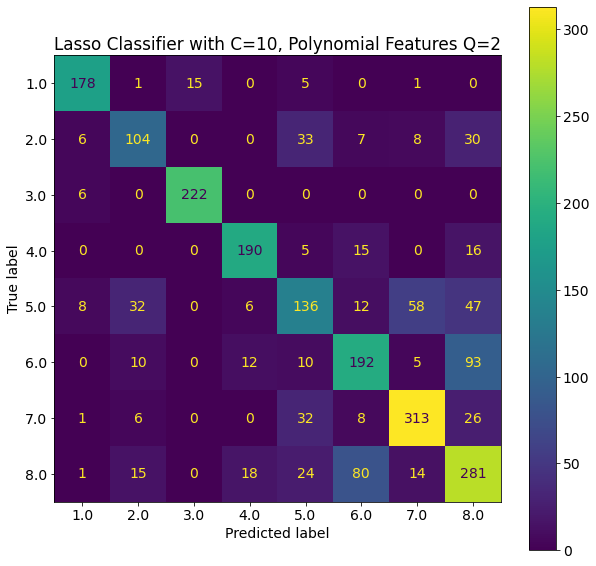

In [80]:
#Lasso
print(classification_report(Y[test], ypred_Lasso))
plot_confusion_matrix(pipe_Lasso, Xpoly, Y)
plt.title("Lasso Classifier with C=10, Polynomial Features Q=2")
plt.savefig("../Images/LassoConfusionMatrix.png")
plt.show()
    

              precision    recall  f1-score   support

         1.0       0.65      0.80      0.72        35
         2.0       0.68      0.47      0.55        45
         3.0       0.86      0.89      0.88        36
         4.0       0.77      0.76      0.76        45
         5.0       0.48      0.34      0.40        58
         6.0       0.62      0.67      0.65        64
         7.0       0.79      0.77      0.78        79
         8.0       0.56      0.67      0.61        94

    accuracy                           0.66       456
   macro avg       0.68      0.67      0.67       456
weighted avg       0.66      0.66      0.66       456



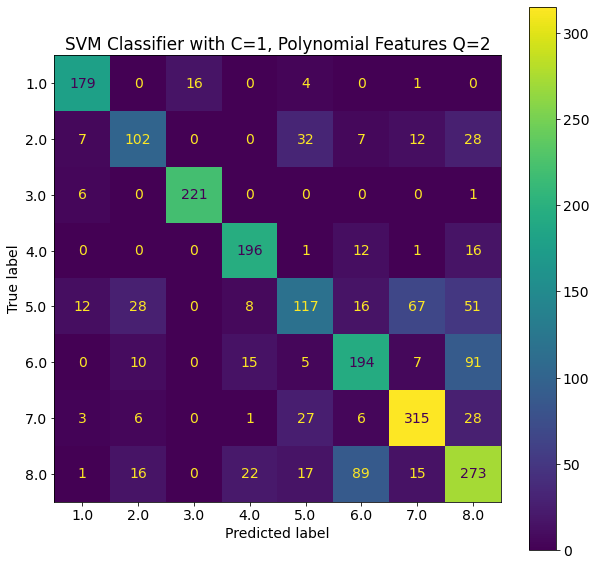

In [81]:
#SVM
print(classification_report(Y[test], ypred_SVM))
plot_confusion_matrix(pipe_SVM, Xpoly, Y)
plt.title("SVM Classifier with C=1, Polynomial Features Q=2")
plt.savefig("../Images/SvmConfusionMatrix.png")
plt.show()